<h1><b>Networks in socio-economic systems </b></h1>
<h3>Prof Luis E C Rocha - luis.rocha@ugent.be</h3>
<h4>Dept of Economics and Dept of Physics and Astronomy</h4>
<h4>Ghent University, Belgium</h4>

<h1><b>Week 3: Fitting power-laws & network measures</b></h1>

<br>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import igraph
import powerlaw as pw
from networkx.utils import powerlaw_sequence

<h2><b>5.</b> (1:45-2:45h) Fitting power-laws</h2>

- Power-laws of the form $f(k)=C k^{-\alpha}$ appear often on network analysis.
- The standard way of fitting a power-law to real data is by taking the log on both axes and fitting a straight line, i.e.
    - $f(k)=C k^{-\alpha}$
    - $\log(f(k)) = \log(C) - \alpha \log(k)$ 
    - $Y = D - \alpha X$
    - $Y := \log(f(k))$
    - $X := \log(k)$
    - $D := \log(C) \rightarrow C = e^{D}$
    - $\alpha$ is the exponent of the power-law
<br><br>
    - these methods might be useful "import numpy as np" | "D = np.log10(C)" | "C = np.exp(D)"
<br><br>
- Some tricks to improve the quality of the fitting:
    - use the cumulative distribution (preferred, see lecture 2). In this case, you must fit the function: $\text{cum}(f(k)) = F(k) = A k^{-\alpha+1}$
    - or use log-bins (i.e. (0-1], (1,2], (2,4], (4, 8], (8, 16], .... ) instead of decimal bins (i.e. (0-2], (2,4], (4,6], (6, 8], ....)
<br><br>
- ***For theory, you can check http://www-personal.umich.edu/~mejn/courses/2006/cmplxsys899/powerlaws.pdf
- Sometimes a power-law with exponential cutoff (i.e. $f(k)= \frac{C} {k^{\alpha}} e^{-\beta k}$) or a log-normal (i.e. $f(x) = \frac{1}{\sigma x\sqrt{2\pi}} e^{-(\log(x) - \mu)^2/2 \sigma^2}$) are more meaningful than a pure power-law!
<br><br>
- There is a module to help fitting power-laws called "powerlaw", go to: https://pypi.org/project/powerlaw/
- You can install the module using Anaconda - environments
- You can install the module by opening the terminal and typing: conda install -c conda-forge powerlaw
- ***For more details on using this module, see this paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777
    - be careful because some methods/options from this module might not work in newer versions of Python... (3.x)
    - this limitation is specially true if you want to add features to plots


<h3> 1. Degree Distribution  </h3> 

In [2]:
# First read the network from file - this format is edge list
A = nx.read_weighted_edgelist('/Users/echo/Desktop/Network/data/week2_collaboration.edgelist.txt', comments = '#', create_using=nx.Graph(), nodetype = int, delimiter=',')#, encoding='utf-8')
B = nx.read_weighted_edgelist('/Users/echo/Desktop/Network/data/week2_email.edgelist.txt',comments = '#', nodetype = int,delimiter=',')
C = nx.read_weighted_edgelist('/Users/echo/Desktop/Network/data/week2_phonecalls.edgelist.txt',comments = '#', nodetype = int,delimiter=',')

# Remove multiple edges
A = nx.Graph(A) 
B = nx.Graph(B) 
C = nx.Graph(C) 

# Remove self-loops
A.remove_edges_from( nx.selfloop_edges(A) )     
B.remove_edges_from( nx.selfloop_edges(B) )   
C.remove_edges_from( nx.selfloop_edges(C) )   


In [3]:
# calculate the average degree: sum of degree/ number of nodes 
ka = [val for (node, val) in nx.degree(A)]               # make a list of degrees for all nodes

print('avg. email: %.4f'% (sum(ka)/nx.number_of_nodes(A)) )  # calculat the average degree of the network

kb = [value for (ind,value) in nx.degree(B)]
print('avg. phone: %.4f'% (sum(kb)/nx.number_of_nodes(B)) )  # calculat the average degree of the network

kc = [value for (ind,value) in nx.degree(C)]
print('avg. collaboration: %.4f'% (sum(kc)/nx.number_of_nodes(C)) )  # calculat the average degree of the network


avg. email: 8.5462
avg. phone: 3.2527
avg. collaboration: 3.4741


In [ ]:
# 度分布的函数

def get_pdf(G,kmin,kmax):
    k=list(range(kmin,kmax+1)) # 所有可能的度值
    n=len(G.nodes())
    
    pk=[]
    for ki in k:
        c=0
        for i in G.nodes():
            if G.degree(i)==ki:
                c+=1
                pk.append(c/n)
                
    return k,pk 
    # k 度值， pk: normalized distribution of k 

In [4]:
# histogram() 去掉了重复值
def histogram(O):
    # Make the histogram of degree, i.e. how many nodes have a certain degree
    d_deg = nx.degree_histogram(O) # get the degree for all nodes 
    d_deg_n = [x / O.number_of_nodes() for x in d_deg] # normalized 
    c_deg = list(range(0,len(d_deg)))
    
    return c_deg,d_deg_n
    

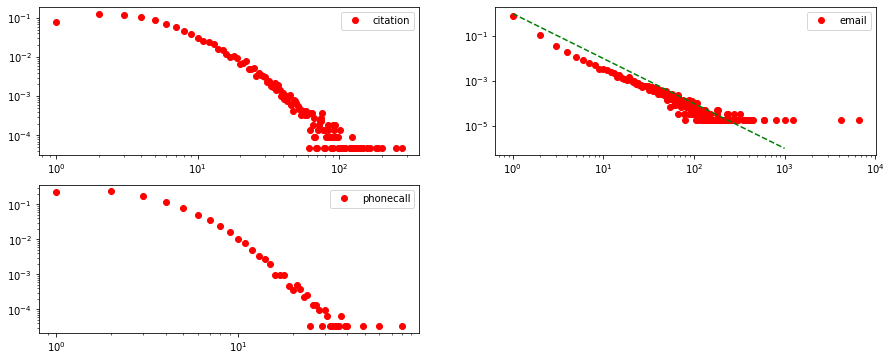

In [5]:
# plot
xa,ya = histogram(A)
xb,yb = histogram(B)
xc,yc = histogram(C)

plt.figure(figsize=(15,6))
plt.subplot(221)
plt.plot(xa,ya,'ro',label='citation')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')


plt.subplot(222)
plt.plot(xb,yb,'ro',label='email')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
# 可以粗略拟合： 2x +b （ 设置斜率=2）
x= list(range(1,1000))
y=[ 1/(x**2) for x in x]
plt.plot(x,y,'g--')


plt.subplot(223)
plt.plot(xc,yc,'ro',label='phonecall')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')


 ==> only email follow power law distribution with long tail of popular email 

<h3> 2. Power law distribution </h3> 
import powelaw  我们需要精确的模拟power law 

In [6]:
# 需要node 所有degree 不需要过滤
print('B- kmax:',max(kb)) # 最大 degree

fit = pw.Fit(kb) 
kmin = fit.power_law.xmin
print('kmin:',kmin) # 精确的拟合下的最小度 （ 度下限）
print('Exponent:',fit.alpha)  # gamma : # Exponent of the power-law alpha - 2.89 和之前的拟合斜率 2差距比较大

# sigma is the standard error of the exponent alpha, i.e. "alpha +- sigma". 
#To calculate the confidence interval (CI) from the error 
#see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808/  C.I (95%)= [alpha +- 1.95*error] 
print("Exponent error: %.4f" % fit.sigma )

print('D-Kolmogorov-Smirnov:',fit.D) 
# D: (goodness of fit) the fit function finds the minimal Kolmogorov-Smirnov "distance" between 
# the data and the fit to a power-law. 
#It is a measure of difference between two distributions. 
#For more details, see https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm



B- kmax: 6553
kmin: 81.0
Exponent: 2.8932255803934517
Exponent error: 0.1200
D-Kolmogorov-Smirnov: 0.028810583944537838


Calculating best minimal value for power law fit
/Applications/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


<AxesSubplot:>

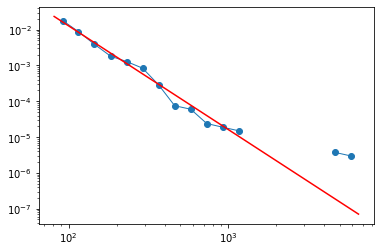

In [11]:
# Simulate PDF after fitting data ( 拟合之后)
fig = fit.plot_pdf(marker='o',linewidth=1)  # Plot the original values considering the output of the fitting function, specially x_min. It also renormalises the distributions
fit.power_law.plot_pdf(color='r',linestyle='-',ax=fig) # Plot a power-law function using the fitted values - calculated above by "fit=pw.Fit(k)" above


#x = list( range(1,1000) )
#y = list( [ 10000/(i**2.89) for i in x ] )   # this is a list comprehension -> for each "i" in the list "x", output 1/(i**2.5)
#plt.plot(x, y, 'r--')



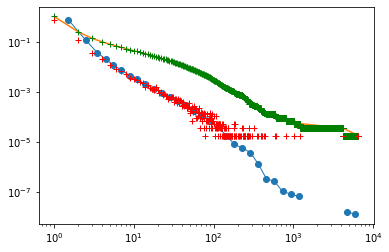

In [9]:
# 拟合前

# To plot the pdf and the cumulative pdf of the degree
pw.plot_pdf(kb,marker='o',linewidth=1) # you can add "linear_bins=True". Default is logarithmic binning
pw.plot_ccdf(kb)

#---------------------------------------------------------------------------------------------------------------------
# function pw.plot_ccdf(k) is equivalent to:

cum_d = len(xb)*[0]
i = 1
while i < len(xb):    
    cum_d[i] = sum( yb[i:len(yb)] )         # calculate the cumulative distribution for each value of degree k
    i += 1                                          # equivalent to i = i + 1
plt.plot(xb, cum_d, 'g+')                        # for the cumulative plot using green crosses
plt.plot(xb, yb, 'r+')                      # for the pdf plot using red crosses
#---------------------------------------------------------------------------------------------------------------------

<h3> 3. Power law sequence  </h3> 
符合power law的 degree sequence

In [13]:
# from networkx.utils import powerlaw_sequence
# 给定exponent 和 degree 个数 => 生成符合power law的 度序列
degree_seq = powerlaw_sequence(10000,exponent=2.5) # 10000个degree sequence with exponent =2,5
int_deg =[int(i)for i in degree_seq]
int_deg[:20]

[1, 1, 1, 1, 1, 1, 14, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
# 也可以直接用pw.Power_Law () function 

# Advanced: It is also possible to generate values (sample values) from a given power-law distribution
# I recommend however to implement the method directly, as explained in Table D.1 (p40) in this paper: https://arxiv.org/abs/0706.1062

theoretical_distribution = pw.Power_Law(xmin=5.0, parameters=[2.5])   # here, one defines the parameters of the theoretical power-law distribution, i.e. x_min and exponent \alpha 
degree_seq = theoretical_distribution.generate_random(10000)       # here, one generates 10000 samples

# degree_seq 是根据xmin 和 exponent 生成的 degree sequence 


In [25]:
# 得到 拟合后的一些参数：
fit = pw.Fit(degree_seq)

print("kmin" % fit.power_law.xmin )
print("Exponent : %.4f" % fit.power_law.alpha )
print("Exponent error: %.4f" % fit.sigma )
print('D-Kolmogorov-Smirnov:',fit.D) 

Calculating best minimal value for power law fit
/Applications/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


kmin
Exponent : 2.5230
Exponent error: 0.0194
D-Kolmogorov-Smirnov: 0.0058114711871003755


<AxesSubplot:>

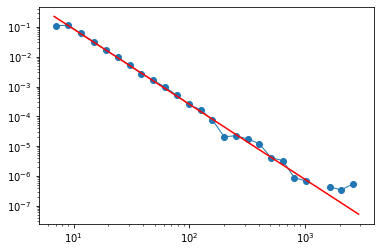

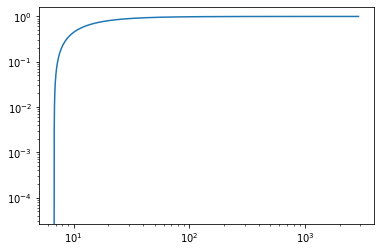

In [26]:
# 拟合后 plot :
fig = fit.plot_pdf(marker='o',linewidth=1)  # Plot the original values considering the output of the fitting function, specially x_min. It also renormalises the distributions
fit.power_law.plot_pdf(color='r',linestyle='-',ax=fig) # Plot a power-law function using the fitted values - calculated above by "fit=pw.Fit(k)" above
fit.power_law.plot_cdf()

<h3> 4. Compare with Log-normal and Exponential</h3>
- Is power-law the best distribution for your data?
- It is often relevant to compare the power-law with the log-normal and with the exponential


In [23]:
# compare power law with log_normal 
R, p = fit.distribution_compare('power_law', 'lognormal')
print("R: %.2f / p-value: %.4f" %(R, p))

#R is the loglikelihood ratio between the two candidate distributions - i.e. the goodness of fit of two competing statistical models 
#If positive, the data is more likely in the first distribution; 
#if negative, the data is more likely in the second distribution.
#The significance value for that direction is p. 
#p <0.05 indicates that the two models are not equal and 
# thus either the first or second distribution is correct (given the direction by R)


# compare power law with others
#R, p = fit.distribution_compare('power_law', 'exponential')
#R, p = fit.distribution_compare('power_law', 'stretched_exponential')   # stretched exponential -> exp(-x^{\beta})
#R, p = fit.distribution_compare('power_law', 'truncated_power_law')



R: 0.10 / p-value: 0.1874


5.043841791852874


Calculating best minimal value for power law fit


x_min: 5.007 / alpha: 2.514 


<AxesSubplot:>

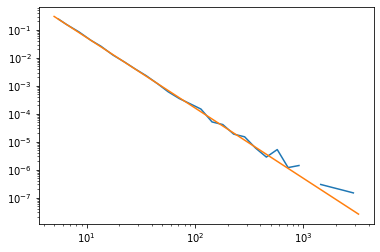

In [ ]:
# You can access the generated samples
samples = list(simulated_data)                                        # list of generated values (i.e. generated degrees "k") in the sample
print(samples[0])                                                     # one value from the sample

# Fit a power-law to the distribution of the generated values in the sample - this is used to double check if the sample generates correct values
fit = pw.Fit(simulated_data)
print( "x_min: %.3f / alpha: %.3f "% (fit.power_law.xmin, fit.power_law.alpha) )

# Plot the simulated data and the fitted data
pw.plot_pdf(simulated_data)                          # plot of the simulated data
fit.power_law.plot_pdf()                             # plot of the best (power-law) fit to the simulated data

<h3> Creating simulated data  </h3>

Individual Distribution objects can generate random data points
with the function generate_random. These Distribution objects
can be called from a Fit object or created manually.

In [12]:
# fit = pw.Fit(kb) 
# you can directly generate random network with 10000 
simitated_data = fit.power_law.generate_random(10000)


In [16]:
# or you can generate random network with fixed xmin and parameters
theoretical_distribution = pw.Power_Law(xmin = 5.0,parameters = [2.5])
simulated_data=theoretical_distribution.generate_random(10000) 


fit = pw.Fit(simulated_data)
print(fit.power_law.xmin,fit.alpha) # 5.8 & 2.5


Calculating best minimal value for power law fit
/Applications/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


5.888714243272156 2.504304493265505


<AxesSubplot:>

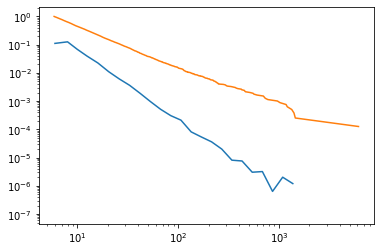

In [18]:
fit.plot_pdf()
fit.plot_ccdf()

<h2><b>7.</b> (2:30-2:45h) Hands on</h2>
<h3> Comparing Networks</h3>

- Go to: http://networksciencebook.com/translations/en/resources/data.html or https://users.ugent.be/~lcorread/courses/week2/

- Download the networks (* you can skip the biological ones (5 and 8); the actor network (1) is very large and thus slow for the calculations)
<br>1) Actor
<br>2) Collaboration
<br>3) Internet
<br>4) Power Grid
<br>5) Protein
<br>6) Phone Calls
<br>7) Citation
<br>8) Metabolic
<br>9) Email
<br>10) WWW

- Ps: Nodes are labelled from 0 continuously. Each line contains two node labels A and B, representing either a directed link A->B or an undirected link A-B. Undirected links appear once in the file.

<h3> Proposed analysis</h3>

- Plot the degree distribution of each network
- Plot the cumulative degree distribution of each network
- Estimate the $x_{min}$ and the exponent $\alpha$ of each network
    - Would be OK to discard nodes with degree $k$ below $x_{min}$? What that means?
<br><br>
- Compare the goodness of fit between power-law and exponential, and power-law and log-normal
    - What does it mean that the distribution better fits to a power-law than an exponential?
- Are there any trends in the fitting parameters for different classes (social vs. technological) of networks?
- Comparatively, what can you say about the distribution of degrees? any practical insights?
<br><br>
- Advanced analyses
    - Repeat the fitting exercise and analysis for other network measures, e.g. clustering coefficient, k-cores, number of triangles
    - Are the exponents of the distributions the same for all networks?
    - Check the original paper or read online other functionalities available in the powerlaw module/library
        - Can you fix $x_{min}$ or $x_{max}$?
        - Can you test the power-law against other competing distributions (besides exponential and log-normal)?
